In [1]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

#   Copyright 2021 UKRI-STFC, Technical University of Denmark
#   Authored by:    Jakob S. Jørgensen (DTU)
#                   Edoardo Pasca (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)

# Introductory demo of Core Imaging Library (CIL) 

### 3D laboratory micro-CT, cone-beam data of walnut

First import all modules we will need:

In [21]:
import numpy as np
import os

from cil.io import TXRMDataReader, TIFFWriter, NEXUSDataWriter
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry

Load the 3D cone-beam projection data of a walnut:

In [3]:
base_dir = os.path.abspath("/mnt/materials/SIRF/Fully3D/CIL/")
data_name = "Egg"
filename = os.path.join(base_dir, data_name, "egg2/gruppe 2_2014-03-20_1105_07/tomo-A/gruppe 2_tomo-A.txrm")

data = TXRMDataReader(file_name=filename).read()

The data is loaded in as a CIL `AcquisitionData` object:

In [4]:
type(data)

cil.framework.framework.AcquisitionData

We can call `print` for the data to get some basic information:

In [5]:
print(data)

Number of dimensions: 3
Shape: (1001, 1024, 1024)
Axis labels: ('angle', 'vertical', 'horizontal')



Note how labels refer to the different dimensions. We infer that this data set contains 1601 projections each size 1024x1024 pixels.

In addition to the data itself, `AcquisionData` contains geometric metadata in an `AcquisitionGeometry` object in the `geometry` field, which can be printed for more detailed information:

In [6]:
print(data.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [   0.     , -295.02942,    0.     ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.      , 35.073414,  0.      ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024, 1024]
	Pixel size: [0.0658542461917172, 0.0658542461917172]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1001
	Angles 0-20 in degrees:
[-179.99751, -179.64047, -179.28058, -178.92033, -178.56085, -178.20062,
 -177.8418 , -177.48021, -177.12196, -176.76251, -176.39967, -176.04112,
 -175.68019, -175.32138, -174.9629 , -174.60144, -174.24113, -173.88066,
 -173.52077, -173.16098]



CIL can illustrate the scan setup visually from the AcquisitionData geometry:

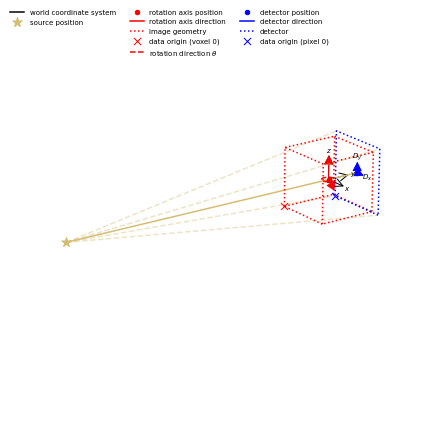

In [7]:
show_geometry(data.geometry)

We can use the dimension labels to extract and display 2D slices of data, such as a single projection:

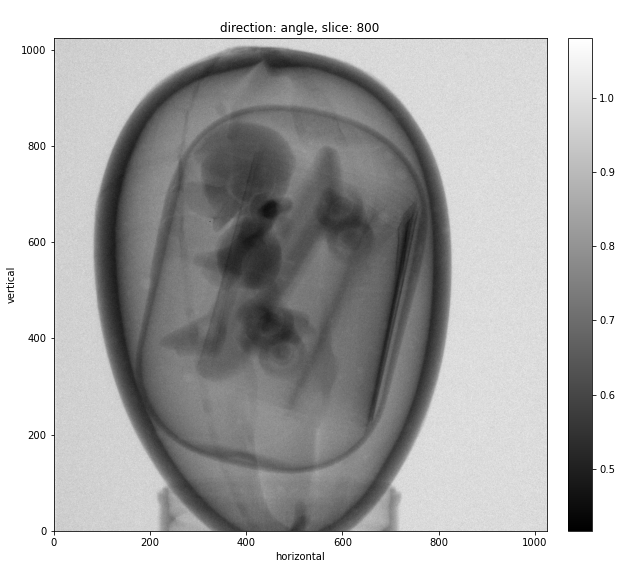

In [8]:
show2D(data, slice_list=('angle',800))

From the background value of 1.0 we infer that the data is transmission data (it is known to be already centered and flat field corrected) so we just need to convert to absorption/apply the negative logarithm, which can be done using a CIL processor, which will handle small/large outliers:

In [9]:
data = TransmissionAbsorptionConverter()(data)

We again take a look at a slice of the data, now a vertical one to see the central slice sinogram after negative logarithm:

/opt/SIRF-SuperBuild/INSTALL/python/cil/utilities/display.py:309: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


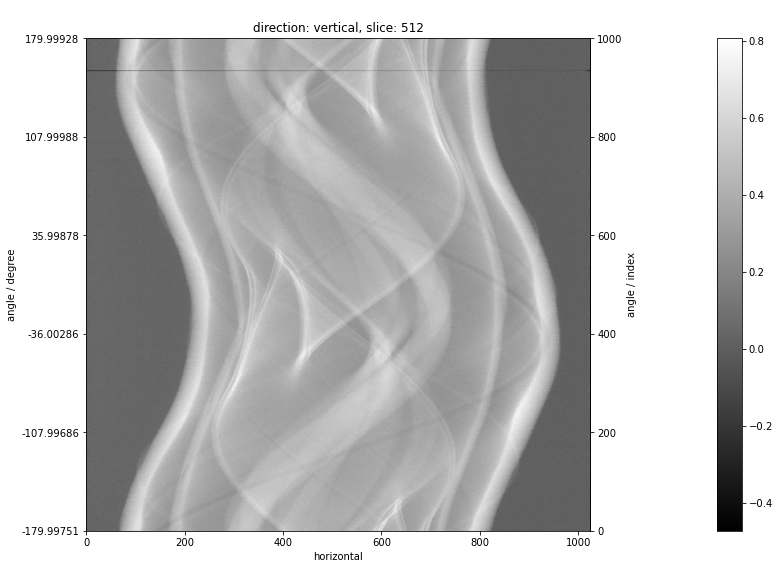

In [10]:
show2D(data, slice_list=('vertical',512))

CIL supports different back-ends for which data order conventions may differ. Here we use the FBP algorithm from the ASTRA Toolbox, which requires us to permute the data array into the right order:

In [11]:
data.reorder(order='astra')

The data is now ready for reconstruction. To set up the FBP algorithm we must specify the size/geometry of the reconstruction volume. Here we use the default one:

In [18]:
ig = data.geometry.get_ImageGeometry()

We can then create the FBP algorithm (really FDK since 3D cone-beam) from ASTRA running on the GPU and reconstruct the data:

In [19]:
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)

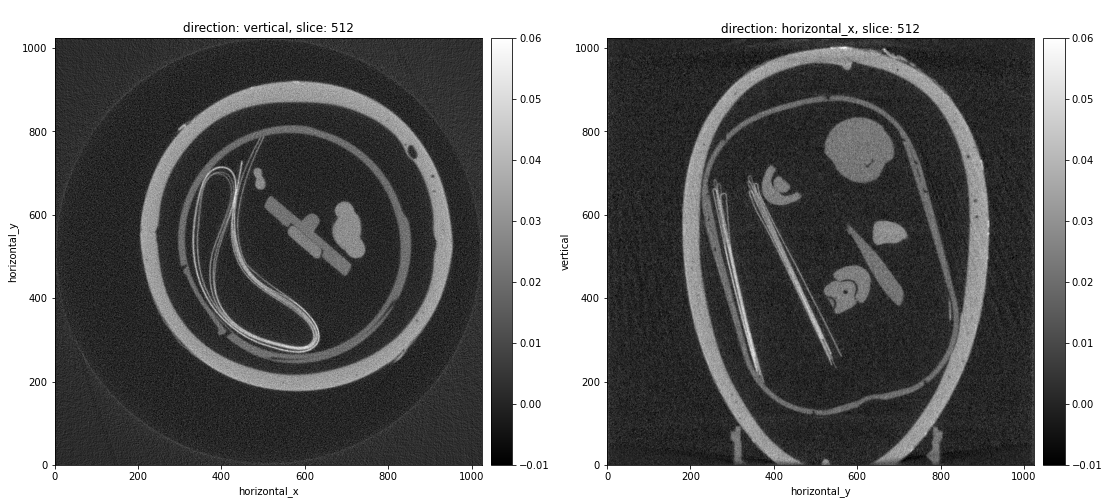

In [20]:
show2D(recon, slice_list=[('vertical',512), ('horizontal_x', 512)], fix_range=(-0.01,0.06))

We can save the reconstructed volume to disk for example as a stack of TIFFs:

In [23]:
save_base_path = os.getcwd()
save_path = os.path.join(save_base_path, data_name)
os.makedirs(save_path)

NEXUSDataWriter(data=recon,file_name=os.path.join(save_path, "out")).write()

# TIFFWriter(data=recon, file_name=os.path.join(save_path, "out").write()

We now demonstrate the effect of reducing the number of projections on the FBP reconstruction.

In [16]:
from cil.processors import Slicer

reduce_factor = 10

data_reduced = Slicer(roi={'angle': (0,-1,reduce_factor)})(data)

ig = data_reduced.geometry.get_ImageGeometry()
fbp =  FBP(ig, data_reduced.geometry, "gpu")
recon_reduced = fbp(data_reduced)

We show the same slices as before:

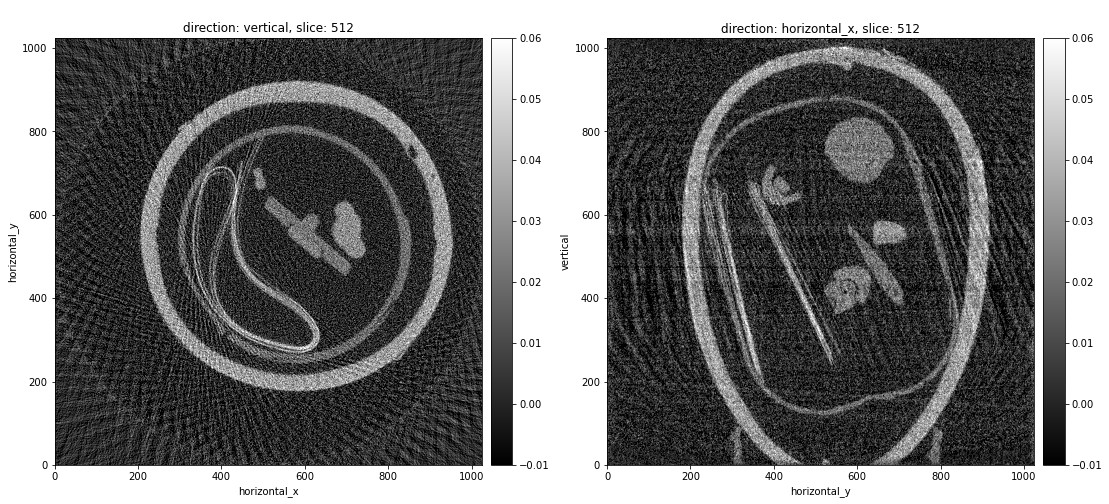

In [17]:
show2D(recon_reduced, slice_list=[('vertical',512), ('horizontal_x', 512)], fix_range=(-0.01,0.06))